In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [0]:
path=untar_data(URLs.CAMVID)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/images')]

In [0]:
path_lbl=path/'labels'
path_img=path/'images'

In [6]:
fnames=get_image_files(path_img)
fnames[:4]

[PosixPath('/root/.fastai/data/camvid/images/0016E5_08310.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06840.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_08153.png'),
 PosixPath('/root/.fastai/data/camvid/images/0001TP_009120.png')]

In [7]:
lbl_names=get_image_files(path_lbl)
lbl_names[:5]

[PosixPath('/root/.fastai/data/camvid/labels/0006R0_f00990_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_08125_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0006R0_f02880_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_009480_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06300_P.png')]

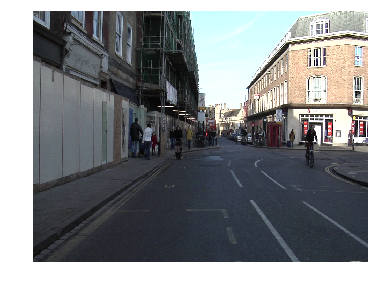

In [11]:
img_f=fnames[0]
img=open_image(img_f)
img.show(figsize=(6,6))

In [0]:
get_y_fn=lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [0]:
mask=open_mask(get_y_fn(img_f))

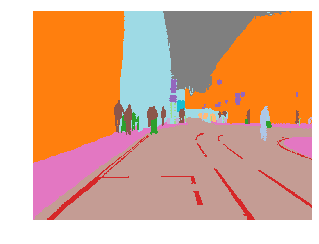

In [14]:
mask.show(figsize=(5,5),alpha=1)

In [17]:
get_y_fn(img_f)

PosixPath('/root/.fastai/data/camvid/labels/0016E5_08310_P.png')

In [0]:
??open_mask

In [23]:
src_size=np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 17, 17,  ..., 17, 17, 17]]]))

In [24]:
codes=np.loadtxt(path/'codes.txt',dtype=str);
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [30]:
size=src_size//2
free=gpu_mem_get_free_no_cache()

if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 15068MB of GPU RAM free


In [0]:
src=(SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
      .label_from_func(get_y_fn,classes=codes))

In [0]:
data=(src.transform(get_transforms(),size=size,tfm_y=True)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

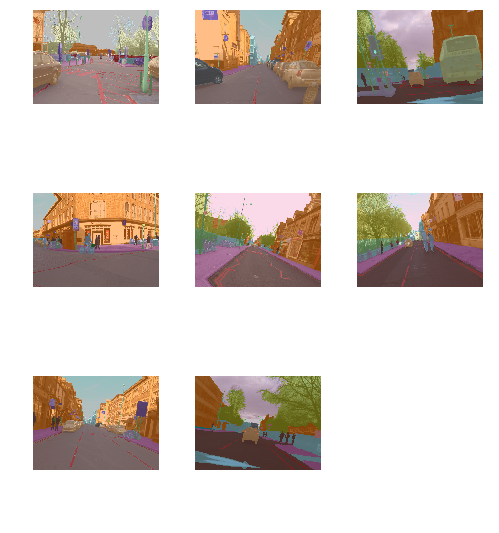

In [36]:
data.show_batch(4,figsize=(7,8))

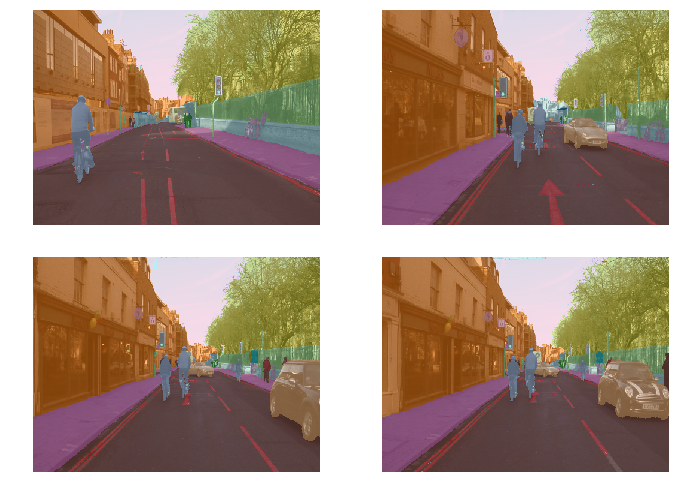

In [37]:
data.show_batch(2,figsize=(10,7),ds_type=DatasetType.Valid)

In [0]:
name2id={v:k for k,v in enumerate(codes)}
void_code=name2id['Void']

def acc_camvid(input,target):
  target=target.squeeze(1)
  mask=target != void_code
  return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
wd=1e-2

In [69]:
learn=unet_learner(data,models.resnet34,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 69303702.23it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


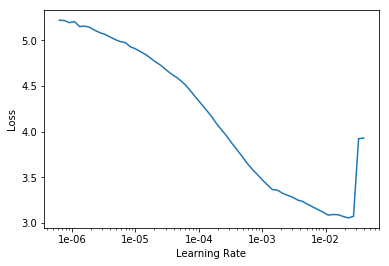

In [70]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=2e-3

In [72]:
learn.fit_one_cycle(10,max_lr=slice(lr),pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.365369,0.798787,0.816740,01:40
1,0.888581,0.705783,0.844359,01:36
2,0.738890,0.602295,0.848311,01:35
3,0.641316,0.496190,0.865735,01:35
4,0.601199,0.496829,0.865900,01:35
5,0.593595,0.465532,0.866636,01:35
6,0.556154,0.423602,0.882051,01:34
7,0.518052,0.386421,0.893622,01:34
8,0.507332,0.444675,0.878657,01:34
9,0.438504,0.323261,0.902554,01:35


In [0]:
learn.save('stage-1')

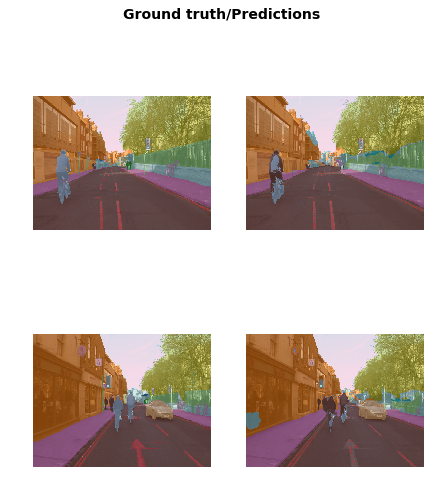

In [74]:
learn.show_results(rows=2,figsize=(7,8))

In [0]:
learn.unfreeze()

In [76]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


AttributeError: ignored

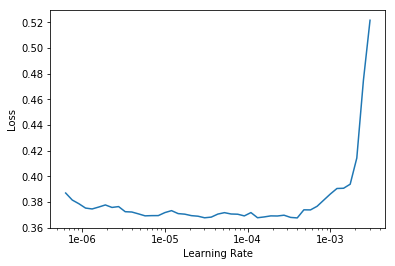

In [78]:

learn.recorder.plot()

In [79]:
learn.fit_one_cycle(10,max_lr=slice(2e-5,1e-3/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.375818,0.310845,0.908619,01:38
1,0.361714,0.299942,0.912926,01:37
2,0.352221,0.315676,0.906633,01:38
3,0.339305,0.286075,0.919067,01:38
4,0.320634,0.282221,0.920316,01:37
5,0.306683,0.278264,0.920282,01:38
6,0.291364,0.267023,0.923878,01:38
7,0.276611,0.260662,0.926135,01:38
8,0.272822,0.268977,0.922743,01:38
9,0.263100,0.267458,0.923281,01:38


In [0]:
learn.save('stage-2')

In [81]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [3]:
size = src_size

free = gpu_mem_get_free_no_cache()

if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

NameError: ignored

In [0]:
data=(src.transform(get_transforms(),size=size,tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn=unet_learner(data,models.resnet34,metrics=metrics,wd=wd)

In [85]:
learn.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (600 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Valid: LabelList (101 items)
x: SegmentationItemList
Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960),Image (3, 720, 960)
y: SegmentationLabelList
ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960),ImageSegment (1, 720, 960)
Path: /root/.fastai/data/camvid/images;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (

In [86]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


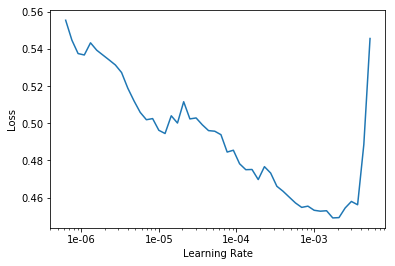

In [87]:
learn.recorder.plot()

In [0]:
lr=8e-4

In [88]:
learn.fit_one_cycle(10,max_lr=slice(lr),pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.376103,0.345073,0.905845,06:27
1,0.350002,0.332856,0.910276,06:23
2,0.393795,0.456435,0.890866,06:22
3,0.408833,0.387108,0.906292,06:20
4,0.430654,0.342198,0.907110,06:18
5,0.467144,0.392433,0.910499,06:17
6,0.402664,0.344409,0.913133,06:16
7,0.413034,0.344581,0.906198,06:15
8,0.343561,0.281464,0.928604,06:14
9,0.272709,0.248055,0.933175,06:14


In [0]:
learn.save('stage-1-big')

In [2]:
learn.load('stage-1-big')

NameError: ignored

In [1]:
learn.lr_find()

NameError: ignored